# SUBJECT 1

## IMPORTS / LOADING DATA

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
#sys.path.insert(0,'../sylber')
#from sylber import Segmenter

In [18]:
#preds, test_y = np.load('preds/sub-01_preds_r0.5_min-0.2_max0.5_f256.npy', allow_pickle=True)
#scores = np.load('scores/sub-01_scores_r0.5_min-0.2_max0.5_f256.npy', allow_pickle=True)
preds, test_y = np.load('preds/sub-01_modehg_r0.8_min-0.5_max0.5_f256_preds.npy', allow_pickle=True)
sylber_data = np.load('./pickled_podcast/outputs.pkl', allow_pickle=True)
sylber_segments = sylber_data['segments']; del sylber_data
#mean_score = np.mean(scores, axis=0)
#print(mean_score)

## SANITY CHECKS

In [19]:
print((preds.shape), (test_y.shape)) # sanity check for size
test_start_time = 30*60 - preds.shape[0]/256 # in seconds
print((test_start_time, test_start_time/60)) # should give 15 minutes of audio


(92160, 768) (92160, 768)
(1440.0, 24.0)


# AUTOCORRELATION

We artificially "upsampled" (see `stepwise_resample()` in `utils.py`) our tokens to match our (reduced) neural data sampling rate. We can try to average over frames to get back to our token sampling rate of $50tok/sec$

In [20]:
def avg_pool(x, sr, target_sr):
    stride = int(sr/target_sr)
    y = [np.average(x[i*stride:min((i+1)*stride, len(x))], axis=0) for i in range(len(x)//stride)]
    return np.array(y)

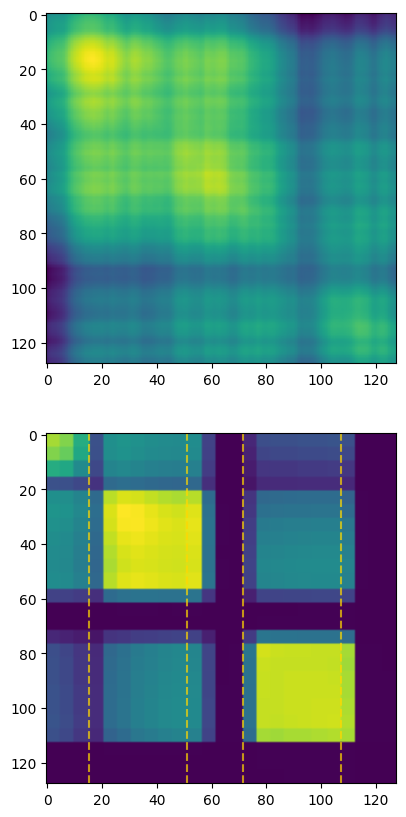

In [32]:
f, (a0, a1) = plt.subplots(2, 1,figsize=(5,10))
# start and end times
# after 15mins
#s, e = 981.5, 982.7
#s, e = 1278, 1279.5
# after 24mins
#s, e = 1526, 1527
s, e = 1620.7, 1621.2

def time_to_rel_idx(t, start=test_start_time, sr=256):
    return int((t - start) * sr)

frame_start, frame_end = time_to_rel_idx(s), time_to_rel_idx(e)

X_frame = preds[frame_start: frame_end]
y_frame = test_y[frame_start: frame_end]
#X_frame, y_frame = avg_pool(X_frame, 256, 50), avg_pool(y_frame, 256, 50)

a0.imshow(X_frame@X_frame.T)
a1.imshow(y_frame@y_frame.T)

# show sylber audio segments
for seg_s, seg_e in sylber_segments:
    # check for segments in the frame
    # with relative start / end
    if (s < seg_s < e) and (s < seg_e < e):
        # normalize wrt frame start, convert to index
        a1.axvline((seg_s-s)*256, color='gold',ls='--',alpha=0.7,label='onset')
        a1.axvline((seg_e-s)*256, color='gold',ls='--',alpha=0.7,label='onset')


# DECODING SCORE RELATIVE TO SYLLABLE ONSET